## Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import anndata as ad
import scanpy as sc
from PIL import Image
import tifffile as tifi
from IPython.display import IFrame
from pathlib import Path
import os; from tqdm import tqdm

In [3]:
import os
import pandas as pd
import anndata as ad

# Define sample list
samples = [f"IMMUNEX{str(i).zfill(3)}" for i in range(1, 19)]
sample = samples[0]
# Base paths
adata_path_template = f"/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_{sample}/outs/binned_outputs/square_002um/filtered_feature_bc_matrix.h5"
patch_path_template = f"/scratch/Projects/IMMUNEX/results/enact_results/250626_001-{sample}/chunks/weighted_by_cluster/bin_to_cell_assign"

samples



['IMMUNEX001',
 'IMMUNEX002',
 'IMMUNEX003',
 'IMMUNEX004',
 'IMMUNEX005',
 'IMMUNEX006',
 'IMMUNEX007',
 'IMMUNEX008',
 'IMMUNEX009',
 'IMMUNEX010',
 'IMMUNEX011',
 'IMMUNEX012',
 'IMMUNEX013',
 'IMMUNEX014',
 'IMMUNEX015',
 'IMMUNEX016',
 'IMMUNEX017',
 'IMMUNEX018']

In [4]:
# Results dictionary for statistics
obs_match_stats = {}
binning = 'square_002um'

for sample in tqdm(samples):
    adata_path = adata_path_template.format(sample=sample)
    patch_dir = patch_path_template.format(sample=sample)

    print(adata_path)
    print(patch_dir)
    sample_export_path = f"/scratch/Projects/IMMUNEX/results/enact_results/processed_enact/250701/{sample}"
    os.makedirs(sample_export_path, exist_ok=True)
    
    if not os.path.exists(adata_path):
        obs_match_stats[sample] = "❌ adata missing"
        print("❌ adata missing")
    if not os.path.exists(patch_dir):
        obs_match_stats[sample] = "❌ patch dir missing"
        print("❌ patch dir missing")
    try:
        # Load adata
        base_path = f"/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_{sample}/outs/binned_outputs/{binning}"
        h5_path = f"{base_path}/filtered_feature_bc_matrix.h5"
        spatial_path = f"{base_path}/spatial/tissue_positions.parquet"
        
        # Load expression
        adata = sc.read_10x_h5(h5_path)
        adata.var_names_make_unique()
        
        # Load spatial
        spatial = pd.read_parquet(spatial_path)
        spatial.set_index("barcode", inplace=True)
        
        # Join spatial metadata into obs
        adata.obs = adata.obs.join(spatial, how="left")
        
        # Assign spatial coordinates
        adata.obsm["spatial"] = adata.obs[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()
        adata

        print(f'adata loaded, shape : {adata.shape}')
        
        # Collect all spatial_join_patch_*.csv files
        patch_files = [f for f in os.listdir(patch_dir) if f.startswith("spatial_join_patch_") and f.endswith(".csv")]
        if not patch_files:
            obs_match_stats[sample] = "❌ no spatial_join_patch_*.csv files found"
            continue

        patch_dfs = [pd.read_csv(os.path.join(patch_dir, f), index_col=1) for f in patch_files]
        merged_df = pd.concat(patch_dfs, axis=0)

        # Check if row indices in merged_df['index'] match adata.obs_names
        matched = merged_df.index.isin(adata.obs_names)
        merged_df['index'] = merged_df.index
        num_total = len(merged_df)
        num_matched = matched.sum()
        obs_match_stats[sample] = f"✅ matched {num_matched}/{num_total}"

        merged_df = pd.concat(patch_dfs, axis=0)
        merged_df = merged_df.loc[merged_df.index.isin(adata.obs_names)]
        
        # Optional: remove duplicates if any
        merged_df = merged_df[~merged_df.index.duplicated(keep="first")]
        
        # Join 'id' column directly into .obs using index alignment
        adata.obs["cell_id"] = merged_df["id"]
        
        # segmented_adata_path = f"{sample_export_path}/segmented_adata_{sample}.h5ad"
        # adata.write(segmented_adata_path)


    except Exception as e:
        obs_match_stats[sample] = f"❌ ERROR: {str(e)}"
        print( f"❌ ERROR: {str(e)}")
    break


  0%|                                                                                                                                                                                                                         | 0/18 [00:00<?, ?it/s]

/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_IMMUNEX001/outs/binned_outputs/square_002um/filtered_feature_bc_matrix.h5
/scratch/Projects/IMMUNEX/results/enact_results/250626_001-IMMUNEX001/chunks/weighted_by_cluster/bin_to_cell_assign


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


adata loaded, shape : (10822530, 18536)


  0%|                                                                                                                                                                                                                         | 0/18 [00:51<?, ?it/s]


In [5]:
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,cell_id
s_002um_00658_01498-1,1,658,1498,49072.541240,72584.407589,ID_95091
s_002um_02587_02503-1,1,2587,2503,66022.627347,63950.896847,ID_379021
s_002um_01674_00710-1,1,1674,710,57893.975667,79557.093281,ID_232843
s_002um_02498_02808-1,1,2498,2808,65268.868357,61276.597239,ID_312052
s_002um_00952_00136-1,1,952,136,51533.762147,84518.653841,NaN
...,...,...,...,...,...,...
s_002um_03318_03089-1,1,3318,3089,72462.439679,58885.183511,ID_425422
s_002um_00212_00415-1,1,212,415,45084.942833,82019.263358,ID_51058
s_002um_03062_00964-1,1,3062,964,70052.723270,77447.487739,NaN
s_002um_00504_01845-1,1,504,1845,47753.805479,69537.584897,ID_90572


In [6]:
import json
from pathlib import Path
import pandas as pd
from imageio import imread
from h5py import File
import scipy.sparse as sp
import re

# --- Define paths ---
# sample = "IMMUNEX001"  # update this per sample
count_file = "filtered_feature_bc_matrix.h5"
base_path = Path(f"/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_{sample}/outs/binned_outputs/square_002um/")

# Find matching .tif image and set image_dir
he_image_root = Path("/home/mounim/rawdata/IMMUNEX/")  # top-level dir
external_img = None
for tif in he_image_root.rglob(f"{sample}_*.tif"):
    external_img = tif
    break  # Use the first match found

if external_img:
    image_dir = external_img.parent
    print(f"✅ Found image at: {external_img}")
    print(f"✅ Using image_dir: {image_dir}")
else:
    raise FileNotFoundError(f"No H&E image found for sample {sample} under {he_image_root}")



# --- Initialize spatial entry ---
adata.uns["spatial"] = {}

# --- Extract library ID from count matrix .h5 ---
with File(base_path / count_file, mode="r") as f:
    attrs = dict(f.attrs)
library_id = str(attrs["library_ids"][0], "utf-8")
adata.uns["spatial"][library_id] = {}
print(f'Lib id from data : {library_id}')

# --- Set tissue position + scale factors file paths ---
image_path = base_path / "spatial"
tissue_pos_file = (
    image_path / "tissue_positions.csv"
    if (image_path / "tissue_positions.csv").exists()
    else image_path / "tissue_positions.parquet"
    if (image_path / "tissue_positions.parquet").exists()
    else image_path / "tissue_positions_list.csv"
)
files = {
    "tissue_positions_file": tissue_pos_file,
    "scalefactors_json_file": image_path / "scalefactors_json.json",
    "hires_image": image_path / "tissue_hires_image.png",
    "lowres_image": image_path / "tissue_lowres_image.png",
}

# --- Load optional hires/lowres images if present ---
adata.uns["spatial"][library_id]["images"] = {}
for res in ["hires", "lowres"]:
    f = files[f"{res}_image"]
    if f.exists():
        adata.uns["spatial"][library_id]["images"][res] = imread(str(f))

# --- Load scalefactors ---
adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
    files["scalefactors_json_file"].read_text()
)

# --- Metadata (chemistry + version) ---
adata.uns["spatial"][library_id]["metadata"] = {
    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    for k in ("chemistry_description", "software_version")
    if k in attrs
}

# --- Load and attach spatial coordinates to .obs ---
if tissue_pos_file.name.endswith(".csv"):
    pos = pd.read_csv(
        tissue_pos_file,
        header=0 if tissue_pos_file.name == "tissue_positions.csv" else None,
        index_col=0,
    )
elif tissue_pos_file.name.endswith(".parquet"):
    pos = pd.read_parquet(tissue_pos_file)
    pos.set_index("barcode", inplace=True)

pos.columns = [
    "in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"
]



✅ Found image at: /home/mounim/rawdata/IMMUNEX/PJ2410310_250214/IMAGE/HE_nanozoomer_tif/IMMUNEX001_Visium_HE_x40_z0.tif
✅ Using image_dir: /home/mounim/rawdata/IMMUNEX/PJ2410310_250214/IMAGE/HE_nanozoomer_tif
Lib id from data : Visium_NSCLC_IMMUNEX001


/tmp/ipykernel_23281/2253676582.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  adata.uns["spatial"][library_id]["images"][res] = imread(str(f))


In [7]:
# --- Merge coordinates into .obs ---
# adata.obs = adata.obs.join(pos, how="left")

# --- Store spatial coordinates ---
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].to_numpy()

# --- Add total counts if missing ---
adata.obs["n_counts"] = adata.X.sum(axis=1).A1 if sp.issparse(adata.X) else adata.X.sum(axis=1)

adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,cell_id,n_counts
s_002um_00658_01498-1,1,658,1498,49072.541240,72584.407589,ID_95091,0.0
s_002um_02587_02503-1,1,2587,2503,66022.627347,63950.896847,ID_379021,16.0
s_002um_01674_00710-1,1,1674,710,57893.975667,79557.093281,ID_232843,5.0
s_002um_02498_02808-1,1,2498,2808,65268.868357,61276.597239,ID_312052,6.0
s_002um_00952_00136-1,1,952,136,51533.762147,84518.653841,NaN,9.0
...,...,...,...,...,...,...,...
s_002um_03318_03089-1,1,3318,3089,72462.439679,58885.183511,ID_425422,18.0
s_002um_00212_00415-1,1,212,415,45084.942833,82019.263358,ID_51058,4.0
s_002um_03062_00964-1,1,3062,964,70052.723270,77447.487739,NaN,0.0
s_002um_00504_01845-1,1,504,1845,47753.805479,69537.584897,ID_90572,3.0


In [8]:
# Extract the numeric part of cell_id (e.g., "ID_379021" -> 379021)
adata.obs["cell_id_numeric"] = (
    adata.obs["cell_id"]
    .astype(str)
    .str.extract(r"ID_(\d+)", expand=False)
    .astype(float)  # Use float to allow for missing values if any
)

adata.obs[adata.obs["cell_id"].isna()]["cell_id"] = 'Non segmented'
adata.obs.head()

/tmp/ipykernel_23281/2661863111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[adata.obs["cell_id"].isna()]["cell_id"] = 'Non segmented'


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,cell_id,n_counts,cell_id_numeric
s_002um_00658_01498-1,1,658,1498,49072.541240,72584.407589,ID_95091,0.0,95091.0
s_002um_02587_02503-1,1,2587,2503,66022.627347,63950.896847,ID_379021,16.0,379021.0
s_002um_01674_00710-1,1,1674,710,57893.975667,79557.093281,ID_232843,5.0,232843.0
s_002um_02498_02808-1,1,2498,2808,65268.868357,61276.597239,ID_312052,6.0,312052.0
s_002um_00952_00136-1,1,952,136,51533.762147,84518.653841,NaN,9.0,NaN


In [14]:
adata.obs["CellId"] = adata.obs["cell_id"].fillna("None")
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,cell_id,n_counts,cell_id_numeric,CellId
s_002um_00658_01498-1,1,658,1498,49072.541240,72584.407589,ID_95091,0.0,95091.0,ID_95091
s_002um_02587_02503-1,1,2587,2503,66022.627347,63950.896847,ID_379021,16.0,379021.0,ID_379021
s_002um_01674_00710-1,1,1674,710,57893.975667,79557.093281,ID_232843,5.0,232843.0,ID_232843
s_002um_02498_02808-1,1,2498,2808,65268.868357,61276.597239,ID_312052,6.0,312052.0,ID_312052
s_002um_00952_00136-1,1,952,136,51533.762147,84518.653841,NaN,9.0,NaN,None
...,...,...,...,...,...,...,...,...,...
s_002um_03318_03089-1,1,3318,3089,72462.439679,58885.183511,ID_425422,18.0,425422.0,ID_425422
s_002um_00212_00415-1,1,212,415,45084.942833,82019.263358,ID_51058,4.0,51058.0,ID_51058
s_002um_03062_00964-1,1,3062,964,70052.723270,77447.487739,NaN,0.0,NaN,None
s_002um_00504_01845-1,1,504,1845,47753.805479,69537.584897,ID_90572,3.0,90572.0,ID_90572


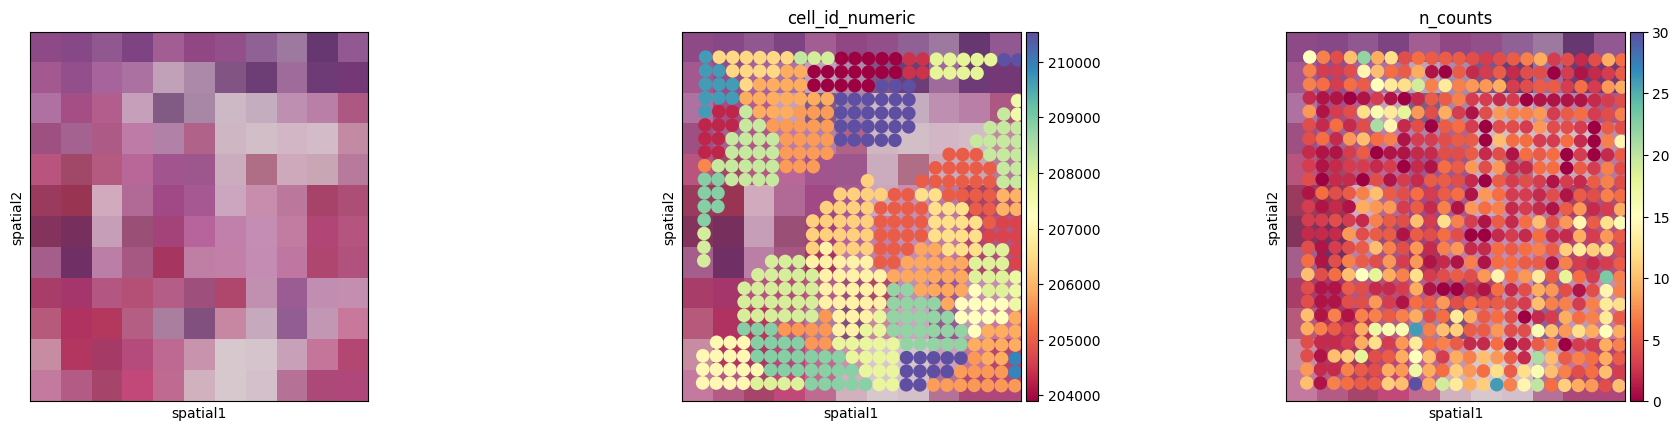

In [23]:
import squidpy as sq
import matplotlib.pyplot as plt

# Ensure cell_id is categorical
adata.obs["cell_id"] = pd.Series(adata.obs_names).astype("category")

# Define crop region
crop_size = 222
x_center, y_center = adata.obsm["spatial"][:, 0].mean(), adata.obsm["spatial"][:, 1].mean()
crop_box = [(x_center - crop_size / 2, y_center - crop_size / 2,
             x_center + crop_size / 2, y_center + crop_size / 2)]


# Plot
sq.pl.spatial_scatter(
    adata,
    color=[None, "cell_id_numeric", "n_counts"],
    crop_coord=crop_box,
    library_id=f"Visium_NSCLC_{sample}",
    img=True,
    size=1,
    cmap="Spectral" 
)


#### ADD UMI per cell (not bins)


In [10]:
from joblib import Parallel, delayed
from scipy.sparse import csr_matrix, vstack
import numpy as np

adata_cells = adata[~adata.obs['cell_id'].isna()].copy()

# Use CSR for efficient row slicing
X = adata_cells.X.tocsr()

cell_ids = adata_cells.obs['cell_id'].values
print('Analysing')

# Map cell_id to integer index
unique_ids, inverse_idx = np.unique(cell_ids, return_inverse=True)
n_cells = len(unique_ids)
n_genes = X.shape[1]
print('Analysing')

# Initialize empty matrix to store the result
# Result will be dense at the end, but small: (n_cells x n_genes)
result = np.zeros((n_cells, n_genes))
print('Analysing')

# Step 1: Pre-group row indices per cell
from collections import defaultdict

row_groups = defaultdict(list)
for i, cid in enumerate(cell_ids):
    row_groups[cid].append(i)

unique_ids = list(row_groups.keys())

# Step 2: Parallel aggregation function
def sum_group(rows):
    return X[rows].sum(axis=0)

# Step 3: Execute in parallel
results = Parallel(n_jobs=150)(
    delayed(sum_group)(row_groups[cid]) for cid in tqdm(unique_ids, desc="Parallel aggregation")
)




Analysing
Analysing
Analysing


Parallel aggregation: 0it [00:00, ?it/s]


In [72]:

from anndata import AnnData

import scipy.sparse as sp
grouped_expr = pd.DataFrame(result, index=unique_ids, columns=adata_cells.var_names)
print('Step done')
csr = sp.csr_matrix(grouped_expr.values)
print('Step done')

adata_cells = ad.AnnData(X=csr)
adata_cells.obs_names = grouped_expr.index
adata_cells.var_names = grouped_expr.columns # Gene Names
print('Step done')

# and 'cell_id' is the grouping key used to generate grouped_expr
# 1. Get a mapping from cell_id → average spatial position
cell_coords = adata.obs[['cell_id']].copy()
cell_coords['x'] = adata.obsm['spatial'][:, 0]
cell_coords['y'] = adata.obsm['spatial'][:, 1]
print('Step done')

# 2. Average spatial position per cell
mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()
print('Step done')

# 3. Match to your grouped_expr.index (cell IDs)
mean_coords = mean_coords.loc[grouped_expr.index]
print('Step done')

# 4. Assign to obsm
adata_cells.obsm['spatial'] = mean_coords.values
print('Step done')

# # Copy the spatial dictionary to cdata
# library_id = list(adata.uns['spatial'].keys())[0]
# adata_cells.uns['spatial'] = {
#     library_id: adata.uns['spatial'][library_id]
# }

adata_cells


Step done
Step done
Step done
Step done


/tmp/ipykernel_6719/2375118819.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()


Step done
Step done
Step done


AnnData object with n_obs × n_vars = 0 × 18536
    obsm: 'spatial'

In [11]:
adata_cells

AnnData object with n_obs × n_vars = 0 × 18536
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'cell_id', 'n_counts', 'cell_id_numeric'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
adata_cells.obs['id'] = adata_cells.obs.index.astype("category")
import squidpy as sq


sq.pl.spatial_scatter(
    adata_cells,
    color=["cell_id_numeric", "n_counts"],
    # crop_coord=crop_box,
    library_id=f"Visium_NSCLC_{sample}",
    img=True,
    size=1.2,
    cmap="rainbow"
)


In [ ]:
# import scanpy as sc

# sc.pl.embedding(
#     adata_cells,
#     basis="spatial",
#     color=['id'],  # Or any obs column
#     size=5
# )


In [42]:
adata_cells.uns['spatial'] = {
    "mock": {
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}

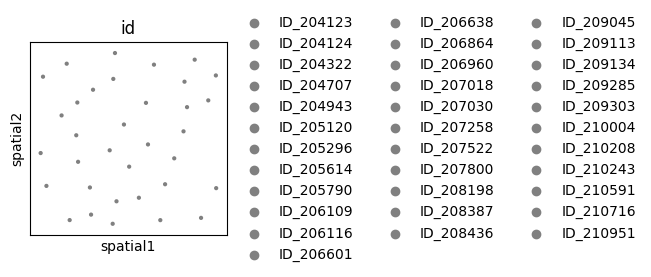

In [47]:
import squidpy as sq
import matplotlib.pyplot as plt

# Crop a region of 222x222 px around the center
x_center, y_center = adata_cells.obsm["spatial"][:, 0].mean(), adata_cells.obsm["spatial"][:, 1].mean()
crop_size = 222

# Calculate bounding box for crop
x0 = x_center - crop_size / 2
x1 = x_center + crop_size / 2
y0 = y_center - crop_size / 2
y1 = y_center + crop_size / 2

# Use 'mock' as the library ID (defined earlier)
sq.pl.spatial_scatter(
    adata_cells,
    color="id",
    crop_coord=[(x0, y0, x1, y1)],
    library_id="mock",
    img=False,
    size=5
)

